In [12]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW", low_memory=False)
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene", low_memory=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# ASD bootstraped biases
biases_match = []
asd_boot_dir = "dat/cont.bias/"
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    biases_match.append(df)

In [16]:
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
str2reg = STR2Region()
str2reg_df = pd.read_csv(MajorBrainDivisions, delimiter="\t")

In [17]:
def CohesivenessProfile(BiasDF, g=g, topNs = topNs, EdgeWeightsDict={}, ):
    EdgeWeightsDict = {}
    ASD_Conn_Z, ASD_Cohe_Z, ASD_Conn_P, ASD_Cohe_P, ASD_Conn_E, ASD_Cohe_E = [],[],[],[],[],[]
    for topN in topNs:
        Permuted_ASD_cohe = []
        Permuted_ASD_conn = []
        Permuted_Sib_cohe = []
        Permuted_Sib_conn = []
        for i in range(100):
            adj_mat_perm = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
            g_perm = LoadConnectome2(adj_mat_perm)
            asd_cohe, asd_conn = ScoreSTRSet(g_perm, BiasDF.head(topN).index.values, EdgeWeightsDict)
            Permuted_ASD_cohe.append(asd_cohe)
            Permuted_ASD_conn.append(asd_conn)
        asd_cohe, asd_conn = ScoreSTRSet(g, BiasDF.head(topN).index.values, EdgeWeightsDict)

        asd_z_conn, asd_p_conn = GetPermutationP(Permuted_ASD_conn, asd_conn)
        asd_z_cohe, asd_p_cohe = GetPermutationP(Permuted_ASD_cohe, asd_cohe)
        effect_conn = asd_conn/np.mean(Permuted_ASD_conn)
        effect_cohe = asd_cohe/np.mean(Permuted_ASD_cohe)
        ASD_Conn_Z.append(asd_z_conn); ASD_Cohe_Z.append(asd_z_cohe)
        ASD_Conn_P.append(asd_p_conn); ASD_Cohe_P.append(asd_p_cohe)
        ASD_Conn_E.append(effect_conn); ASD_Cohe_E.append(effect_cohe)
    return ASD_Cohe_E, ASD_Cohe_P

In [18]:
topNs = list(range(200, 10, -10))

In [28]:
toplotbootE = []
toplotbootP = []
for i in range(100):
    BootE, BootP = CohesivenessProfile(biases_match[i])
    toplotbootE.append(BootE)
    toplotbootP.append(BootP)

In [33]:
toplotbootE.shape

(100, 19)

In [34]:
toplotbootE = np.array(toplotbootE)
toplotbootE.mean(axis=0).shape

(19,)

In [51]:
def addline(TopNs, Eff, ax, color="grey", ls="dashed", alpha=1):
    ax.plot(TopNs, Eff, color=color, ls="solid", lw=3, alpha=alpha)

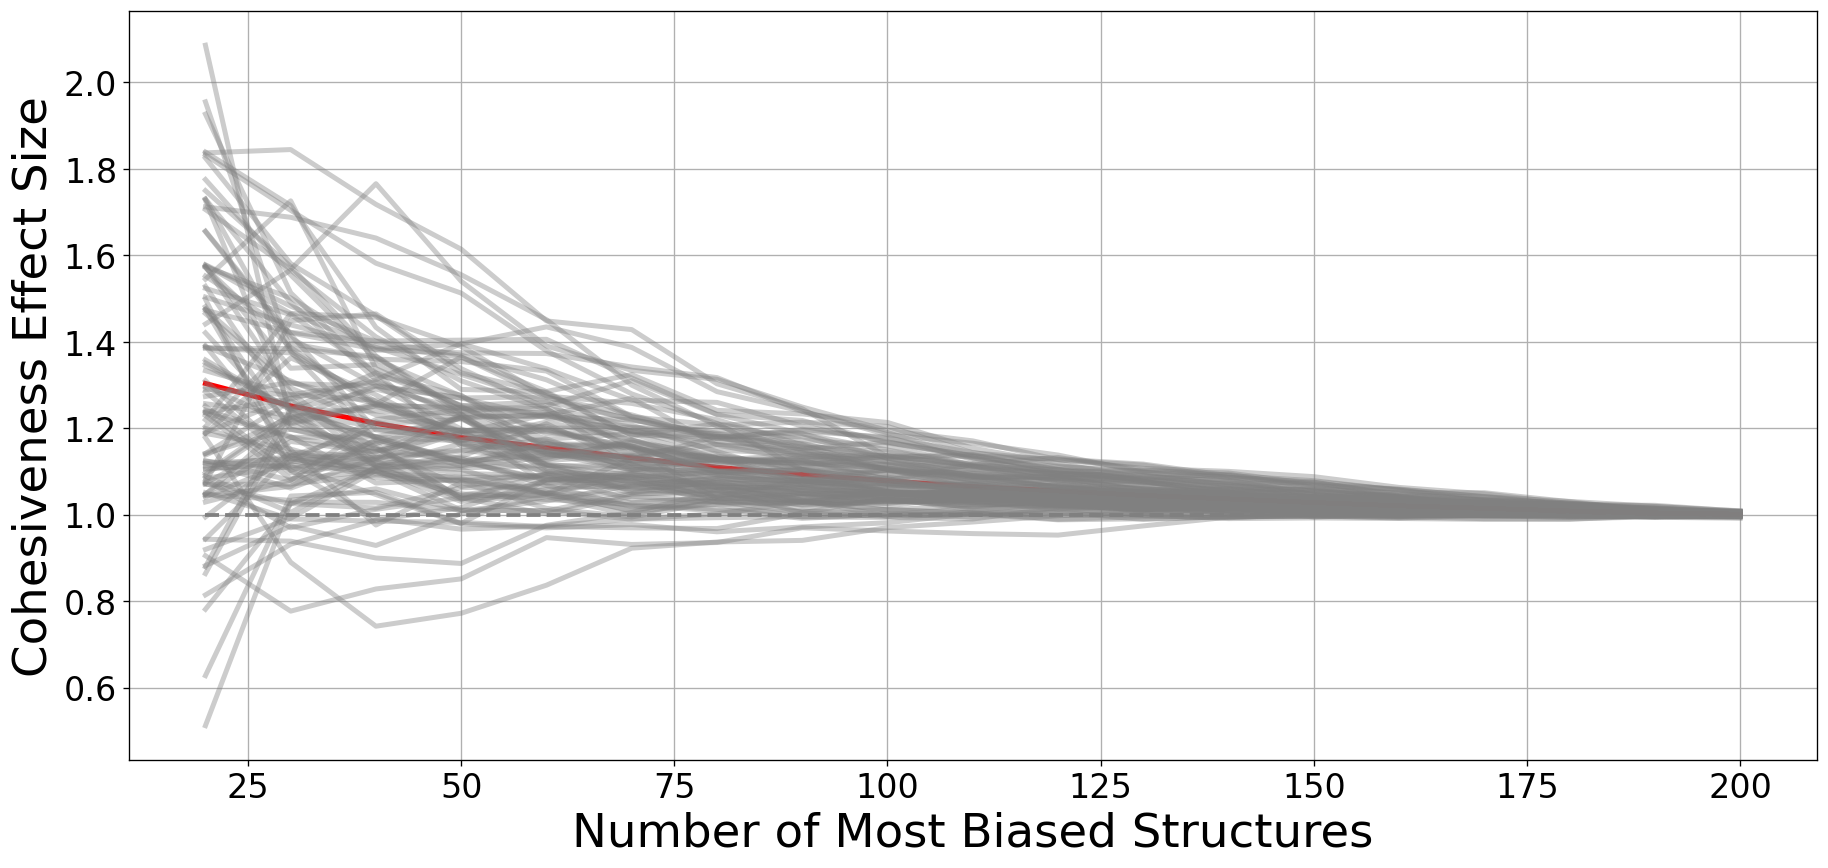

In [52]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(dpi=120, figsize=(16,8))
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 32})

ax.hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
ax.grid(True)

addline(topNs, toplotbootE.mean(axis=0), ax, "red")
for i in range(100):
    addline(topNs, toplotbootE[i], ax, "grey", alpha=0.4)


#ax.legend(fontsize=24, loc="lower right")
ax.set_ylabel("Cohesiveness Effect Size",fontsize=28)
ax.set_xlabel("Number of Most Biased Structures",fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()
#plt.savefig("figs/Fig_2.b.pdf")

In [60]:
#
print(topNs[15])
count = 0
for i, (EE, PP) in enumerate(zip(toplotbootE, toplotbootP)):
    #print(PP[15])
    if EE[15] > 1.25 and PP[15] < 0.01:
        count += 1
        print(i)
print(count)

50
0
3
6
8
9
13
19
22
23
27
29
30
35
42
43
59
60
61
62
71
77
87
93
96
99
25


In [73]:
RegionDistributions(biases_match[60], show=True)

Hypothalamus 	 1 	 Medial_mammillary_nucleus
Medulla 	 20 	 Nucleus_raphe_magnus; Facial_motor_nucleus; Medullary_reticular_nucleus_ventral_part; Gigantocellular_reticular_nucleus; Intermediate_reticular_nucleus; Parvicellular_reticular_nucleus; Spinal_nucleus_of_the_trigeminal_interpolar_part; Spinal_nucleus_of_the_trigeminal_oral_part; Paragigantocellular_reticular_nucleus_dorsal_part; Magnocellular_reticular_nucleus; Medullary_reticular_nucleus_dorsal_part; Lateral_vestibular_nucleus; Paragigantocellular_reticular_nucleus_lateral_part; Lateral_reticular_nucleus; Spinal_vestibular_nucleus; Superior_vestibular_nucleus; Nucleus_of_the_solitary_tract; Nucleus_ambiguus; Inferior_olivary_complex; Dorsal_cochlear_nucleus
Midbrain 	 6 	 Dorsal_nucleus_raphe; Central_linear_nucleus_raphe; Pedunculopontine_nucleus; Midbrain_reticular_nucleus; Red_nucleus; Interpeduncular_nucleus
Thalamus 	 2 	 Posterior_limiting_nucleus_of_the_thalamus; Medial_geniculate_complex_medial_part
Pallidum 	 1 	 Glo

{'Hypothalamus': ['Medial_mammillary_nucleus'],
 'Isocortex': [],
 'Amygdalar': [],
 'Medulla': ['Nucleus_raphe_magnus',
  'Facial_motor_nucleus',
  'Medullary_reticular_nucleus_ventral_part',
  'Gigantocellular_reticular_nucleus',
  'Intermediate_reticular_nucleus',
  'Parvicellular_reticular_nucleus',
  'Spinal_nucleus_of_the_trigeminal_interpolar_part',
  'Spinal_nucleus_of_the_trigeminal_oral_part',
  'Paragigantocellular_reticular_nucleus_dorsal_part',
  'Magnocellular_reticular_nucleus',
  'Medullary_reticular_nucleus_dorsal_part',
  'Lateral_vestibular_nucleus',
  'Paragigantocellular_reticular_nucleus_lateral_part',
  'Lateral_reticular_nucleus',
  'Spinal_vestibular_nucleus',
  'Superior_vestibular_nucleus',
  'Nucleus_of_the_solitary_tract',
  'Nucleus_ambiguus',
  'Inferior_olivary_complex',
  'Dorsal_cochlear_nucleus'],
 'Midbrain': ['Dorsal_nucleus_raphe',
  'Central_linear_nucleus_raphe',
  'Pedunculopontine_nucleus',
  'Midbrain_reticular_nucleus',
  'Red_nucleus',
  'In